In [1]:
from TwitterClient import TwitterClient
from PreProcessor import *
from clustering import KMeans
import matplotlib.pyplot as plt

# Create Dataset

In [2]:
api = TwitterClient()
api.createDataset('messi.txt', '#Messi', 20000)

# Read Data

In [3]:
f = open('./Datasets/messi.txt', 'r')
tweets = f.read().split('_$_')
f.close()

In [4]:
tweets

['RT @BlazquezFont: Robert Lewandowski ha logrado marcar 69 goles en un mismo año natural. Tanto él como Cristiano Ronaldo siguen muy lejos d…',
 'RT @n_rsports: การทำประตูมากที่สุดในหนึ่งปีปฏิทิน😲 \n\n#messi #ronaldo #lewandowski https://t.co/KolPM4VxyS',
 'การทำประตูมากที่สุดในหนึ่งปีปฏิทิน😲 \n\n#messi #ronaldo #lewandowski https://t.co/KolPM4VxyS',
 'RT @CanalSupporters: Le but de Lionel Messi🇦🇷 face à Manchester City est élu plus beau but de la phase de groupes d’#UCL\xa0 ! \n\n#PSG #Messi h…',
 'RT @sportsposting: Casemiro × Messi × Ramos 🔥\nWeird scene at UCL this season 🤣🤣\n\n#MESSI #PSG #MessiPSG https://t.co/TNHx3ZgSKo',
 'RT @Mich_est_la: @MiniLicorne69 @sylvita30 Il envoie son idiot utile pour se présenter lui en #messi dans quelques temps !!! tu sais juste…',
 "RT @Mich_est_la: @sylvita30 @MiniLicorne69 Il y a plusieurs mois que j'écris qu'il envoie ses pimprenelles et les autres pour faire le sale…",
 'RT @RayHudson: we saw it so often didn`t we?...the #GOAT #Messi could b

# Preprocess

In [5]:
processed_tweets = PreProcessor(tweets).preProcess()

In [6]:
len(processed_tweets)

12

In [7]:
c = CreateFreqs(processed_tweets)

In [8]:
freqs = c.createFreqs()

In [9]:
freq_sorted = c.createFreqSorted()

In [10]:
vectors = Vectorizer(processed_tweets, freq_sorted).textVectorize()

In [11]:
alphabet = [i[0] for i in freq_sorted]

# Clustering

In [12]:
kmeans = KMeans(4, 100, vectors, alphabet)

In [13]:
clusters = kmeans.run()

In [14]:
clusters

{0: [0, 1, 2, 4, 5, 6, 7, 9, 10], 1: [11], 2: [3], 3: [8]}

In [15]:
print("No of tweets: " + str(len(processed_tweets)))

No of tweets: 12


In [16]:
print("No of features: " + str(len(alphabet)))

No of features: 106


In [17]:
plotData = dict()
for key in clusters.keys():
    plotData[key] = len(clusters[key])

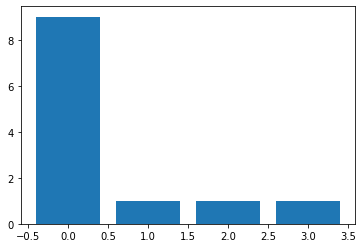

In [18]:
plt.bar(*zip(*plotData.items()))
plt.show()